Test Notebook Kaggle - Neuronales Netz Bakery 24

Daten einlesen

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os

# Dateine einlesen
umsatz_df = pd.read_csv('train.csv')
kiwo_df = pd.read_csv('kiwo.csv')
wetter_df = pd.read_csv('wetter.csv')
prognose_df = pd.read_csv('sample_submission.csv')

# Datum zu datetime-Objekten
umsatz_df['Datum'] = pd.to_datetime(umsatz_df['Datum'])
kiwo_df['Datum'] = pd.to_datetime(kiwo_df['Datum'])
wetter_df['Datum'] = pd.to_datetime(wetter_df['Datum'])

# Mergen
data = pd.merge(umsatz_df, kiwo_df, on='Datum', how='left')
data = pd.merge(data, wetter_df, on='Datum', how='left')


# Ändern der Anzeigeoptionen
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


print(data.shape)
data.head()
# data.to_csv('data.csv', index=False)



(9334, 9)


,id,Datum,Warengruppe,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode
0,1307011,2013-07-01,1,148.828353,NaN,6.0,17.8375,15.0,20.0
1,1307021,2013-07-02,1,159.793757,NaN,3.0,17.3125,10.0,NaN
2,1307031,2013-07-03,1,111.885594,NaN,7.0,21.0750,6.0,61.0
3,1307041,2013-07-04,1,168.864941,NaN,7.0,18.8500,7.0,20.0
4,1307051,2013-07-05,1,171.280754,NaN,5.0,19.9750,12.0,NaN


Formatieren

In [23]:
# Variable merged_df geändert zu data

# Define categorical features
categorical_features = ['Warengruppe', 'Bewoelkung', 'Wettercode']

# Inspect data types and unique values for categorical columns
print(data[categorical_features].dtypes)
print("Unique Values:\n",data[categorical_features].apply(lambda x: x.unique()))

# Ensure categorical columns are treated as categories
for col in categorical_features:
    data[col] = data[col].astype('category')

# Encode categorical variables using pd.get_dummies
features = pd.get_dummies(data[categorical_features], drop_first=True, dtype=int)

# Include any numeric columns that are not categorical
# features['sqft_living15'] = data['sqft_living15']

# Construct the prepared data set including the dependent variable ('label')
prepared_data = pd.concat([data[['Umsatz']], features], axis=1).dropna()

# Handle missing values by removing rows with any missing values
prepared_data = prepared_data.dropna()

# Display the shape of the prepared data set
print(prepared_data.shape)
# Display the first few rows of the prepared data set
prepared_data.head()

Warengruppe      int64
Bewoelkung     float64
Wettercode     float64
dtype: object
Unique Values:
 Warengruppe                                   [1, 2, 3, 4, 5, 6]
Bewoelkung     [6.0, 3.0, 7.0, 5.0, 0.0, 2.0, 1.0, 4.0, 8.0, ...
Wettercode     [20.0, nan, 61.0, 5.0, 21.0, 65.0, 63.0, 95.0,...
dtype: object
(9334, 36)


,Umsatz,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,Bewoelkung_1.0,Bewoelkung_2.0,Bewoelkung_3.0,Bewoelkung_4.0,Bewoelkung_5.0,Bewoelkung_6.0,Bewoelkung_7.0,Bewoelkung_8.0,Wettercode_3.0,Wettercode_5.0,Wettercode_10.0,Wettercode_17.0,Wettercode_20.0,Wettercode_21.0,Wettercode_22.0,Wettercode_28.0,Wettercode_45.0,Wettercode_49.0,Wettercode_53.0,Wettercode_61.0,Wettercode_63.0,Wettercode_65.0,Wettercode_68.0,Wettercode_69.0,Wettercode_71.0,Wettercode_73.0,Wettercode_75.0,Wettercode_77.0,Wettercode_79.0,Wettercode_95.0
0,148.828353,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,159.793757,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,111.885594,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,168.864941,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,171.280754,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Selection of Training, Validation and Test Data

In [24]:
# Set a random seed for reproducibility
np.random.seed(42)

# Shuffle the data
prepared_data = prepared_data.sample(frac=1).reset_index(drop=True)

# Calculate the number of rows for each dataset
n_total = len(prepared_data)
n_training = int(0.8 * n_total)
n_validation = int(0.10 * n_total)

# Split the features and labels for training, validation, and test
training_data = prepared_data.iloc[:n_training]
validation_data = prepared_data.iloc[n_training:n_training+n_validation]
test_data = prepared_data.iloc[n_training+n_validation:]

# Separating features and labels
training_features = training_data.drop('Umsatz', axis=1)
validation_features = validation_data.drop('Umsatz', axis=1)
test_features = test_data.drop('Umsatz', axis=1)

training_labels = training_data[['Umsatz']]
validation_labels = validation_data[['Umsatz']]
test_labels = test_data[['Umsatz']]

# Print dimensions of the dataframes
print("Training features dimensions:", training_features.shape)
print("Validation features dimensions:", validation_features.shape)
print("Test features dimensions:", test_features.shape)
print()
print("Training labels dimensions:", training_labels.shape)
print("Validation labels dimensions:", validation_labels.shape)
print("Test labels dimensions:", test_labels.shape)

Training features dimensions: (7467, 35)
Validation features dimensions: (933, 35)
Test features dimensions: (934, 35)

Training labels dimensions: (7467, 1)
Validation labels dimensions: (933, 1)
Test labels dimensions: (934, 1)


Daten anzeigen

In [26]:
# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())

Loaded Training features dimensions: (7467, 35)
Loaded Validation features dimensions: (933, 35)
Loaded Test features dimensions: (934, 35)

Loaded Training labels dimensions: (7467, 1)
Loaded Validation labels dimensions: (933, 1)
Loaded Test labels dimensions: (934, 1)

First few rows of loaded training features:
   Warengruppe_2  Warengruppe_3  Warengruppe_4  Warengruppe_5  Warengruppe_6  \
0              0              1              0              0              0   
1              0              0              1              0              0   
2              0              1              0              0              0   
3              1              0              0              0              0   
4              0              0              0              1              0   

   Bewoelkung_1.0  Bewoelkung_2.0  Bewoelkung_3.0  Bewoelkung_4.0  \
0               0               0               0               0   
1               0               0               0               

Convertieren zu Numpy

In [27]:
# Convert DataFrames to numpy arrays
training_features_array = training_features.to_numpy()
training_labels_array = training_labels.to_numpy().flatten()  # Flatten in case labels are a DataFrame with one column

print("Training Features Array:")
print(training_features_array[:5])

Training Features Array:
[[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]


Defining the Neural Network
Now, let's define our neural network. We are using a Sequential model definition from Keras with batch normalization and dense layers.

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
  InputLayer(input_shape=(training_features.shape[1], )),
  BatchNormalization(),
  Dense(10, activation='relu'),
  Dense(4, activation='relu'),
  Dense(1)
])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 35)             │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549 (2.14 KB)

 Trainable params: 479 (1.87 KB)

 Non-trainable params: 70 (280.00 B)

Compiling and Training the Model
We will compile the model using Mean Squared Error (MSE) as the loss function and Adam optimizer. The model is then trained using the training data.

In [29]:
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

history = model.fit(training_features, training_labels, epochs=10,
                    validation_data=(validation_features, validation_labels))

Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 62563.1094 - val_loss: 51709.2305
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40368.6211 - val_loss: 17769.1855
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17644.0957 - val_loss: 15195.1035
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15739.9189 - val_loss: 12288.3057
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13231.3369 - val_loss: 9447.1641
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9294.5176 - val_loss: 8374.8779
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7856.0513 - val_loss: 7931.6816
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7725.2676 - val_loss: 7830.4155
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8754.6592 - val_loss: 7734.8438
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8458.1982 - val_loss: 7544.7295


Saving the Trained Model
After training, it's a good practice to save the model for future use.

In [ ]:
#model.save("python_model_LP_v1_2.keras")

Plotting Training History
Visualizing the training and validation loss can help us understand the model's performance over time.

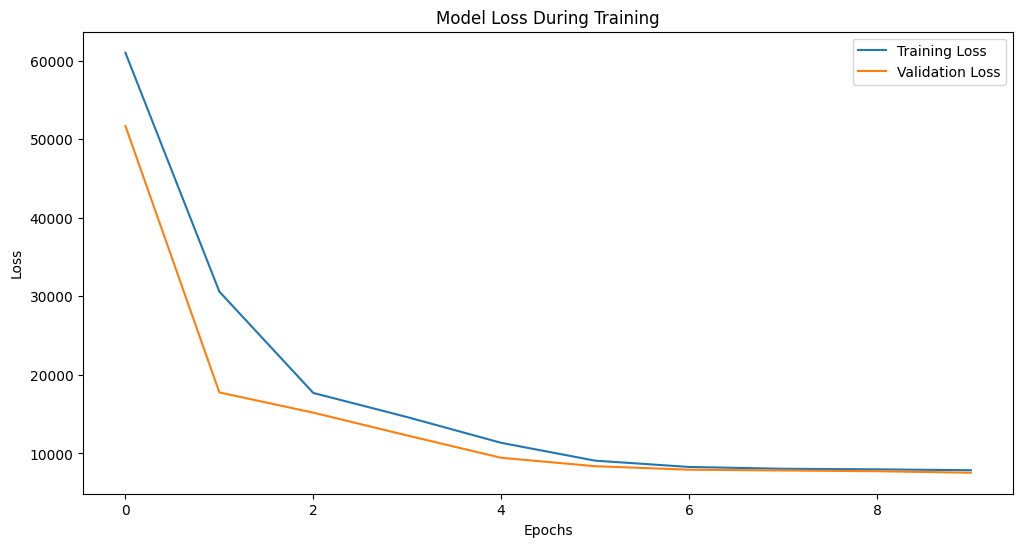

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Making Predictions and Evaluating the Model
Let's use the model to make predictions on our training and validation sets and evaluate the model's performance using Mean Absolute Percentage Error (MAPE).

In [31]:
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
MAPE on the Training Data: 34.05%
MAPE on the Validation Data: 34.03%


Visualizing Predictions vs Actual Values
Visualizing the predicted versus actual values can provide insights into the model's accuracy.

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


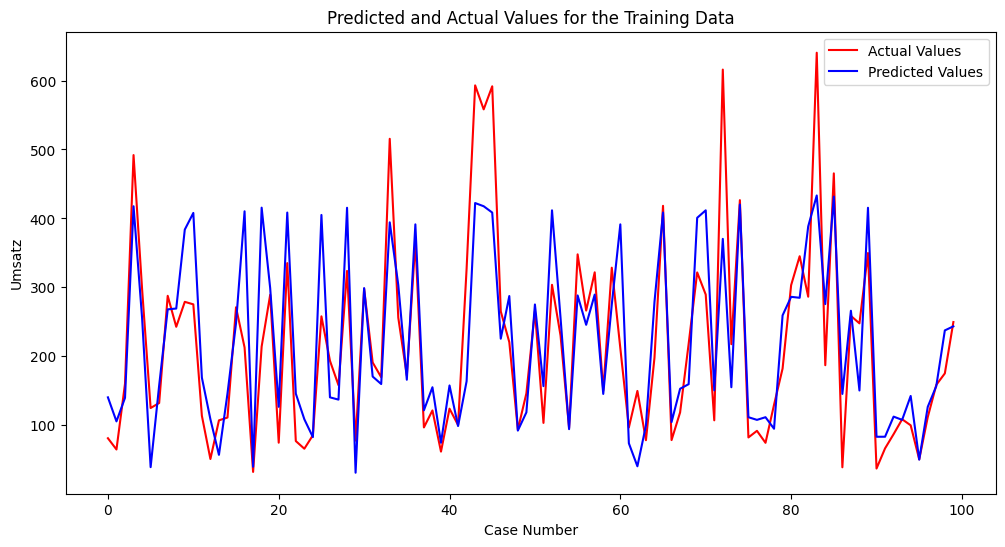

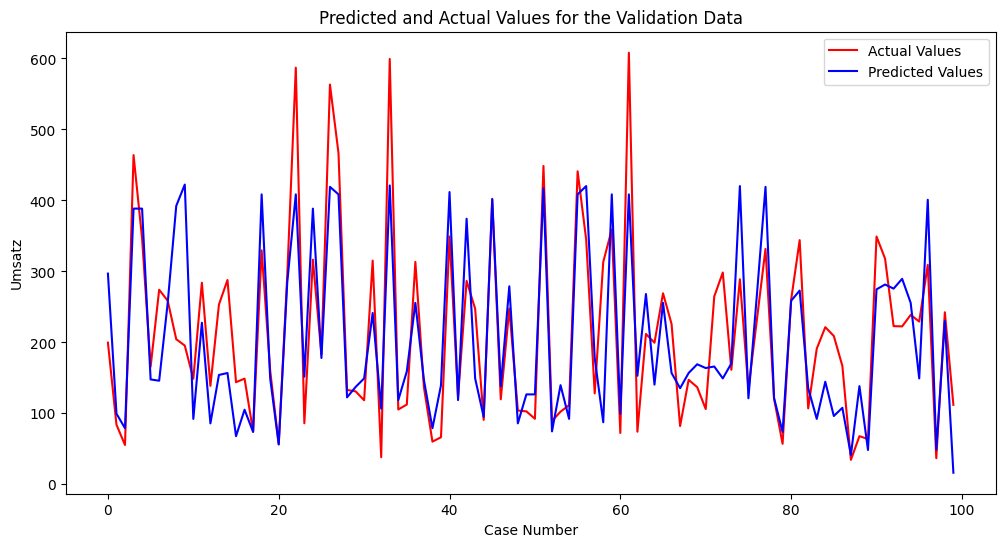

In [32]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Case Number')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

Print Prediction

In [33]:
# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions})

print (data_validation.head())

   prediction      actual
0  296.896637  199.633863
1   99.614838   84.062708
2   79.098495   55.450872
3  388.448303  463.812197
4  388.448303  346.374494


Save Prediction to csv

In [ ]:
#df.to_csv('out.csv', index=True)